In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import datetime, time
from scipy.interpolate import griddata

https://en.wikipedia.org/wiki/Geographic_coordinate_system

On the WGS84 spheroid, the length in meters of a degree of latitude at latitude φ (that is, the distance along a north–south line from latitude (φ − 0.5) degrees to (φ + 0.5) degrees) is about

    111132.92 − 559.82 cos ⁡ 2 φ + 1.175 cos ⁡ 4 φ − 0.0023 cos ⁡ 6 φ 

Similarly, the length in meters of a degree of longitude can be calculated as

    111412.84 cos ⁡ φ − 93.5 cos ⁡ 3 φ + 0.118 cos ⁡ 5 φ 
    
(Those coefficients can be improved, but as they stand the distance they give is correct within a centimetre.)  

In [11]:
class particle_tracking():
    """
    Particle tracking function
    EF is euler foreward scheme
    RK4 is  the Runge-Kutta scheme after: 
    https://nl.wikipedia.org/wiki/Runge-Kuttamethode
    for the interpolation between gridpints the nearest-point method is used.
    
    This method assumes:
    - rectangular or curvilinear grid
    - WGS84 coordinates
    
    the class flow should contain:
    - x,y,t as a numpy meshgrid (y, x, t = np.meshgrid(y, x, t))
    - u, v
    - u.shape = v.shape = x.shape = y.shape = t.shape
    """
    
    def __init__(self, x0, y0, T, flow):
        """Initialis the class with the input data"""
        self.x0 = x0
        self.y0 = y0
        self.T = T
        self.flow = flow
        self.dt = self.T[1] - self.T[0]
        
        lat = y0 * 2* np.pi / 360
        self.mdeg_lat = 111132.92\
                        - 559.82 * np.cos(2*lat)\
                        + 1.175 * np.cos(4*lat)\
                        - 0.0023 * np.cos( 6 * lat)
        self.mdeg_lon = 111412.84 * np.cos(lat)\
                        - 93.5 * np.cos(3*lat)\
                        + 0.118 * np.cos(5*lat)
        
    def EF(self):
        """This method finds the path with the Euler foreward scheme"""
        x0 = self.x0
        y0 = self.y0
        x = [self.x0]
        y = [self.y0]
        for t in self.T:
            if t > self.flow.t[0,0,-1] or t < self.flow.t[0,0,0]:
                print('time out of range of the hydrodynamic model')
                break
            else:
                x0, y0 = self.numeric_scheme_EF(x0,y0,t)
                x.append(x0)
                y.append(y0)
        return x, y
    
    def RK4(self):
        """ This method finds the path with the RK4 scheme"""
        x0 = self.x0
        y0 = self.y0
        x = [self.x0]
        y = [self.y0]
        for t in self.T:
            if t > self.flow.t[0,0,-1] or t < self.flow.t[0,0,0]:
                print('time out of range of the hydrodynamic model')
                break
            else:
                x0, y0 = self.numeric_scheme_RK4(x0,y0,t)
                x.append(x0)
                y.append(y0)
        return x, y      
        
    def numeric_scheme_EF(self, x, y, t):
        """This method contains the euler foreward sheme"""
        u, v = self.interpol(x, y, t)
        
        x = x + self.dt * u # / self.mdeg_lon
        y = y + self.dt * v # / self.mdeg_lat
        
        return x,y
    
    def numeric_scheme_RK4(self, x, y, t):
        """This method contains the RK4 sheme"""

        u0, v0 = self.interpol(x,
                               y,
                               t,
                              )
        K1_x =  self.dt*u0
        K1_y =  self.dt*v0
        
        u1, v1 = self.interpol(x+K1_x/2,
                               y+K1_y/2,
                               t + self.dt/2, 
                              )
        K2_x = self.dt*u1
        K2_y = self.dt*v1
        
        u2, v2 = self.interpol(x+K2_x/2,
                               y+K2_y/2,
                               t + self.dt/2, 
                              )
        K3_x = self.dt*u2
        K3_y = self.dt*v2
        
        u3, v3 = self.interpol(x+K3_x,
                               y+K3_y,
                               t + self.dt, 
                              )
        K4_x = self.dt*u3
        K4_y = self.dt*v3
 
        x = x + (1/6)*(K1_x + K2_x + K3_x + K4_x) #/ self.mdeg_lon
        y = y + (1/6)*(K1_y + K2_y + K3_y + K4_y) #/ self.mdeg_lat
        
        return x,y
    
    def interpol(self, x, y, t):
        """ this function returns the specific flow condtions 
        for a given point in space and time"""
        DD = (self.flow.x[:,:,0] - x) ** 2 + (self.flow.y[:,:,0] - y)** 2 
        i = np.argwhere(DD == DD.min())[0]
        TT = (self.flow.t[0,0,:] - t)**2
        ii = np.argwhere(TT == TT.min())[0,0]
       
        return self.flow.u[i[0], i[1], ii], self.flow.v[i[0], i[1], ii]

In [12]:
class flow():
    def __init__(self, N = 100):
        x = np.linspace(0,1,N)
        y = np.linspace(0,1,N)
        t = np.linspace(0,10, 1000)
        y, x, t = np.meshgrid(y, x, t)
        
        u = np.cos(np.pi*y)
        v = -np.cos(np.pi*x)
    
        self.x = x
        self.y = y
        self.t = t
        self.u = u
        self.v = v
        
class flow2():
    def __init__(self, N = 100):
        x = np.linspace(0,1,N)
        y = np.linspace(1,2,N)
        t = np.linspace(0,10, 1000)
        y, x, t = np.meshgrid(y, x, t)
        
        u =  np.cos(np.pi*(y-1)) * np.cos(2*np.pi / 10 * t)
        v = -np.cos(np.pi*x) * np.cos(2*np.pi / 10 * t)
    
        self.x = x
        self.y = y
        self.t = t
        self.u = u
        self.v = v

In [13]:
f = flow2()
x0 = 0.3
y0 = 1.3
T = np.linspace(0,10, 1000)

start = time.time()
pt = particle_tracking(x0, y0, T, f)
stop = time.time()
print('computation time is',np.round(stop - start,2))

computation time is 0.04


computation time is 0.65
computation time is 3.02


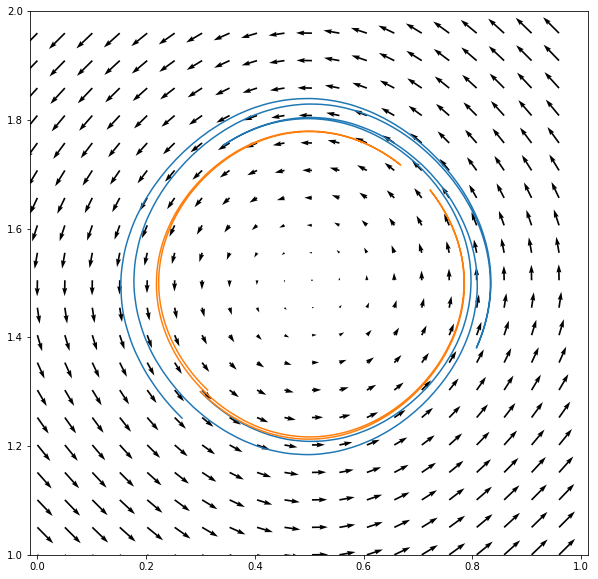

In [14]:
% matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.axis('equal')

a = 5

plt.quiver(f.x[::a,::a,0],
           f.y[::a,::a,0],
           f.u[::a,::a,0],
           f.v[::a,::a,0]
          )
start = time.time()
plt.plot(pt.EF()[0], pt.EF()[1])
stop = time.time()
print('computation time is',np.round(stop - start,2))

start = time.time()
plt.plot(pt.RK4()[0], pt.RK4()[1])
stop = time.time()
print('computation time is',np.round(stop - start,2))

plt.xlim(0,1)
plt.ylim(1,2)

plt.show()

In [15]:
x,y = pt.RK4()

<IPython.core.display.Javascript object>


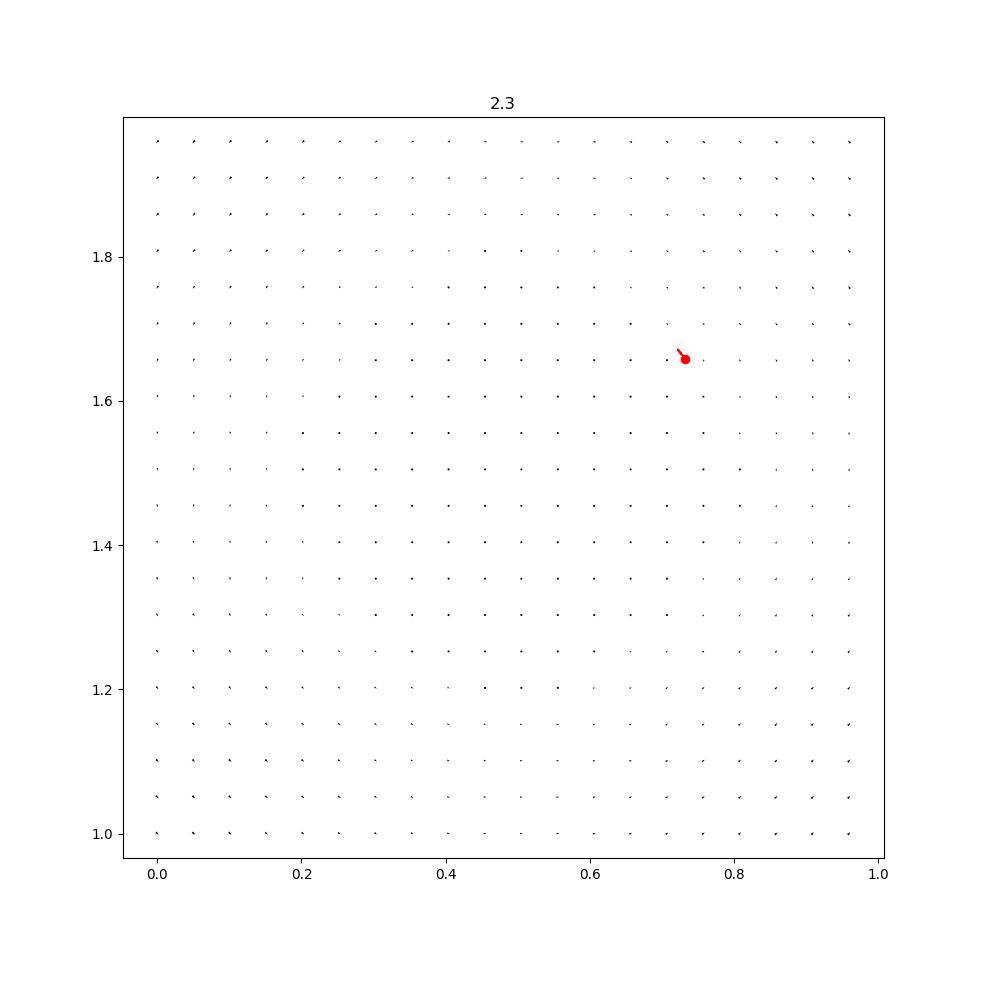

In [18]:
import matplotlib.animation as animation
% matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.axis('equal')

a = 5

q = plt.quiver(f.x[::a,::a,0],
               f.y[::a,::a,0],
               f.u[::a,::a,0],
               f.v[::a,::a,0],
               pivot='mid'
          )


l1, = plt.plot([],[], 'r')
l2, = plt.plot([],[],'ro')

def update_line(i, l1, l2, q):
    i = i*5
    Q = int((i)/(len(f.t[0,0,:])))
    i = i - Q * (len(f.t[0,0,:]))
    plt.title(np.round(f.t[0,0,i],1))
    l1.set_data(x[i:i+50], y[i:i+50])
    l2.set_data(x[i+50], y[i+50])
    
    q.set_UVC(f.u[::a,::a,i],
              f.v[::a,::a,i]
          )
    
    return l1, l2, q
    
animation.FuncAnimation(fig, update_line, fargs=[l1, l2, q], interval=100, repeat = True)